# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

from models.SOGP import GaussianProcess
from acquisition_functions.SingleObjective import SingleObjectiveAcq
from benchmarkFunctions.ackley import ackley

from acquisition_functions.SingleObjective import pi, ei, ucb, mes,  simulated_mes 
from benchmarkFunctions.eggholder import eggholder

## Algorithm Arguments

In [2]:
seed = 1
np.random.seed(seed)
total_iter = 38
initial_iter = 2

lower_bound = -2
upper_bound = 2


## Evaluation

In [3]:
d = 2

def evaluation(x):
    return ackley(x)


N = 1001
X = np.linspace(lower_bound,upper_bound,N)

if d==1:
    Z = np.zeros(N)
    for i in range(N):
        Z[i]=evaluation(X[i])
    opt_arg, opt_val = Z.argmin(), np.amin(Z)    

elif d==2:
    Z = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            Z[i,j]=evaluation(np.array([X[i],X[j]]))

    opt_arg, opt_val = np.unravel_index(Z.argmin(), Z.shape), np.amin(Z)

0.0 0.0 4.440892098500626e-16 4.440892098500626e-16


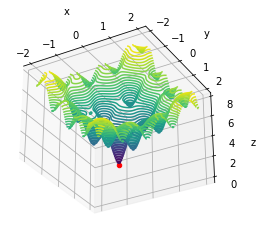

In [4]:
if d==1:
    plt.plot(X, Z)
    plt.plot(X[opt_arg], opt_val, 'or', markersize=5)
    print(X[opt_arg], Z[opt_arg], opt_val)    
elif d==2:
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter3D(X[opt_arg[0]], X[opt_arg[1]], opt_val, color="r")
    ax.contour3D(X, X, Z, 50,cmap='viridis')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.view_init(elev=-30)

    print(X[opt_arg[0]], X[opt_arg[1]], Z[opt_arg], opt_val)

In [5]:
def random_acq(GP):
    while True:
        x_rand = np.random.uniform(GP.lowerBound, GP.upperBound, GP.d)
        if GP.X is None or not x_rand in GP.X:
                break
    return x_rand

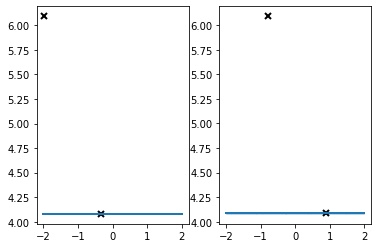

In [6]:
savename = ""
with tf.device('/GPU:1'):
    ### GPs Initialization
    GP = GaussianProcess(d, lower_bound, upper_bound, noise_variance=2e-6)

    #### Initial samples, at least 1
    for l in range(initial_iter):
        ## Get random evaluation point
        x_rand = random_acq(GP)

        ## EVALUATION OF THE OUTSIDE FUNCTION
        y_rand = evaluation(x_rand)
        GP.addSample(x_rand,y_rand)

    GP.updateGP()
    GP.optimizeKernel()
    if True:
        GP.plotSamples()

    row = {
        'ns' : len(GP.X),
        'x'  : x_rand,
        'y'  : y_rand,
        'acq': 0
    }
    metrics = GP.evaluateOptimum(opt_val)
    row.update(metrics)
    df = pd.DataFrame({k: [v] for k, v in row.items()})

#pi(GP, np.array([0]))
fig, axs = plt.subplots(3,1, figsize=(4,15))

X = np.linspace(lower_bound,upper_bound,N).reshape(-1,1)
## Real
axs[0].plot(X, evaluation(X), 'C0', label="Funcion real")
## Modelo
mean, var = GP.GPR.predict_y(X)
print(np.amin(mean))
axs[1].plot(X, mean, 'C0', label="Modelo")
axs[1].fill_between(X[:,0],
                mean[:,0] - 2*np.sqrt(var[:,0]),
                mean[:,0] + 2*np.sqrt(var[:,0]),
                color='C0', alpha=0.2)

## acquisition functions
X_pi = pi(GP, X)
axs[2].plot(X, X_pi, "C1", label="pi")
axs[2].plot(X[np.argmax(X_pi)], X_pi[np.argmax(X_pi)], "XC1")
X_ei = ei(GP, X)
axs[2].plot(X, X_ei, "C2", label="ei")
axs[2].plot(X[np.argmax(X_ei)], X_ei[np.argmax(X_ei)], "C2X")
X_ucb = ucb(GP, X)
axs[2].plot(X, X_ucb, "C3", label="ucb")
axs[2].plot(X[np.argmax(X_ucb)], X_ucb[np.argmax(X_ucb)], "C3X")
X_mes = mes(GP, X, M=1)
axs[2].plot(X, X_mes, "C4", label= "mes")
axs[2].plot(X[np.argmax(X_mes)], X_mes[np.argmax(X_mes)], "C4X")
axs[2].legend()
axs[1].axvline(x = X[np.argmax(X_pi)], color="C1")
axs[1].axvline(x = X[np.argmax(X_ei)], color="C2")
axs[1].axvline(x = X[np.argmax(X_ucb)], color="C3")
axs[1].axvline(x = X[np.argmax(X_mes)], color="C4")

## N experiments

TypeError: Invalid shape (25, 25, 2) for image data

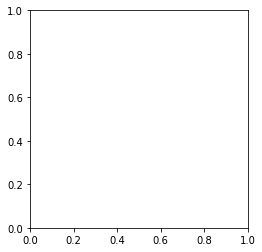

In [8]:
with tf.device('/GPU:1'):

    for l in range(4):

        ## Search of the best acquisition function
        start = time.time()
        x_best, acq = simulated_mes(GP)
        end = time.time()
        print(x_best, acq)

        ## EVALUATION OF THE OUTSIDE FUNCTION
        y_best = evaluation(x_best)

        ## UPDATE
        GP.addSample(x_best,y_best)     ## Add new sample to the model
        GP.updateGP()                   ## Update data on the GP regressor
        GP.optimizeKernel()             ## Optimize kernel hyperparameters

        ## Evaluate Pareto (distances and hypervolumes)
        row = {
            'ns' : len(GP.X),
            'x'  : x_best,
            'y'  : y_best
        }
        metrics = GP.evaluateOptimum(opt_val)
        row.update(metrics)

        df = pd.concat([df, pd.DataFrame({k: [v] for k, v in row.items()})])

In [ ]:
df